In [66]:
import jax.numpy as jnp
import jax
import equinox as eqx
import cryojax as cx
import cryojax.simulator as cxs
import src.ensemble_sim as sim
import os

import numpyro
import numpyro.distributions as dist

import logging
from functools import partial

import matplotlib.pyplot as plt

from cryojax.utils import get_filter_spec
from cryojax.utils._filtered_transformations import filter_vmap_with_spec
from cryojax.constants import get_tabulated_scattering_factor_parameters
from cryojax.io import read_atoms_from_pdb


# Create list of pdb files for simulating images from

In [67]:
path_to_models="data/hsp90_models"
model_fnames = []
for model_fname in sorted(os.listdir(path_to_models)):
    model_fnames.append(model_fname)


# Define a weight distribution on the pdb files
## Here, evaluating a gaussian mixture pdf on the indices of the pdbs

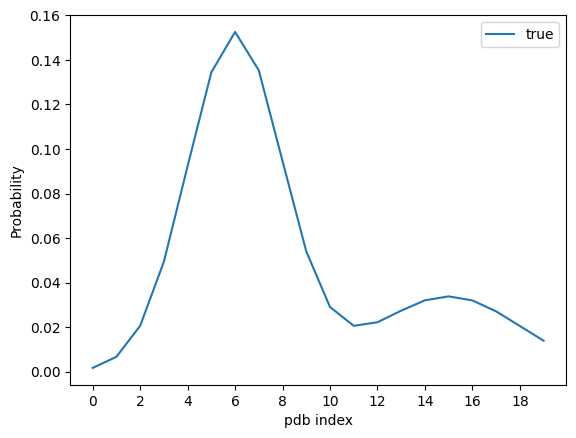

In [68]:
def GaussianMixture1D(weights, means, std_devs):
    weights = jnp.array(weights)
    means = jnp.array(means)
    std_devs = jnp.array(std_devs)
    mixing_dist = dist.Categorical(probs=weights/jnp.sum(weights))
    component_dist = dist.Normal(loc=means, scale=std_devs) 
    return dist.MixtureSameFamily(mixing_dist, component_dist) 

weights = [1., 1./3.]
means = [6., 15.]
std_devs = [2.0, 3.0]
mixture = GaussianMixture1D(weights, means, std_devs)
samples = mixture.sample(jax.random.PRNGKey(0), (10000,))
 
# compute pdf output on a 1d grid
x = jnp.linspace(0, 19, 20)
dx = x[1] - x[0]
    
# normalize output to integrate to 1 on the grid 
weights = jnp.exp(mixture.log_prob(x))
weights /= dx*weights.sum() 
plt.plot(x, weights, label='true', color="C0")
plt.xticks(jnp.arange(0, 20, 2))
plt.xlabel('pdb index')
plt.ylabel('Probability')  
plt.legend()
plt.show()


# Define a config file for image simulation

In [69]:
# Bare bones config for this notebook
# Things that may need to be adjusted:
#   number of images, noise_snr
# Everything else, unlikely

config = {
"number_of_images": 100,
"noise_snr": 1000,
"weights_models": weights,
"models_fnames": model_fnames, 
"path_to_models": path_to_models, 
"box_size": 128,
"rng_seed": 0,
"pixel_size": 1.6,
}

In [70]:
# Create static image formation stuff
imaging_args = sim.build_image_formation_stuff(config)

# Create noise stuff
noise_grid = jnp.linspace(
                 -0.5 * (config["box_size"] - 1),
                 0.5 * (config["box_size"] - 1),
                 config["box_size"],
             )
noise_radius = 0.5*config["box_size"] - 1 # For now, using a disc that is radius of the image for SNR calculations
noise_args = noise_grid, noise_radius, config["noise_snr"] 

def get_pipeline_info(imaging_pipeline):
    """Custom function for returning various stats from an imaging pipeline"""
    info = {}
    info["conformation"] = imaging_pipeline.scattering_theory.structural_ensemble.conformation.value  
    #info["..."] = ...

    return info

# NOTE: here there is no argument at all for weights, since the weight dist is defined in config
def sample_images(key, config, imaging_args, noise_args):

    # Generate RNG keys for individual images
    key, *subkeys = jax.random.split(key, config["number_of_images"] + 1)
    subkeys = jnp.array(subkeys)
    
    # Pipeline
    # NOTE: these extra `eqx.combine' lines are just here because we are paying the piper for having very specific vmaps 
    imaging_pipeline_vmap, imaging_pipeline_novmap = sim.make_imaging_pipeline(subkeys, imaging_args)
    imaging_pipeline = eqx.combine(imaging_pipeline_vmap, imaging_pipeline_novmap)

    extra_info = get_pipeline_info(imaging_pipeline)

    noised_images, noise_power_sq = sim.compute_image_stack_with_noise(key, config, imaging_pipeline, noise_args)
    
    return noised_images, extra_info, imaging_pipeline_vmap, imaging_pipeline_novmap, noise_power_sq



# Simulate a dataset!

In [71]:
key = jax.random.PRNGKey(config["rng_seed"])
noised_images, extra_info, observed_imaging_pipeline_vmap, observed_imaging_pipeline_novmap, noise_power_sq = sample_images(key,config, imaging_args, noise_args)


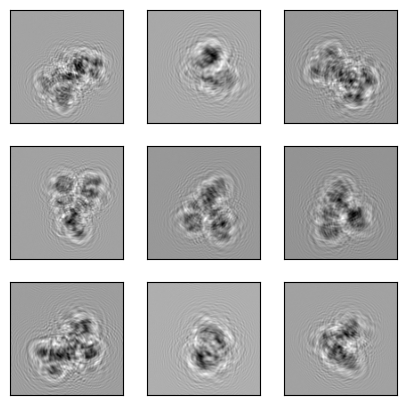

In [72]:
fig, axes = plt.subplots(3, 3, figsize=(5, 5))
for idx, ax in enumerate(axes.reshape(-1)):
    ax.imshow(noised_images[idx,:], cmap="gray")
    ax.set_yticks([])
    ax.set_xticks([])
#plt.savefig(f"figures/noised_images", dpi=300)


## Checking the conformation idx of each individual image
This is a quick check that the sampled conformations actually match the distribution we specified, and a simple use of the per-image conformation info we are tracking

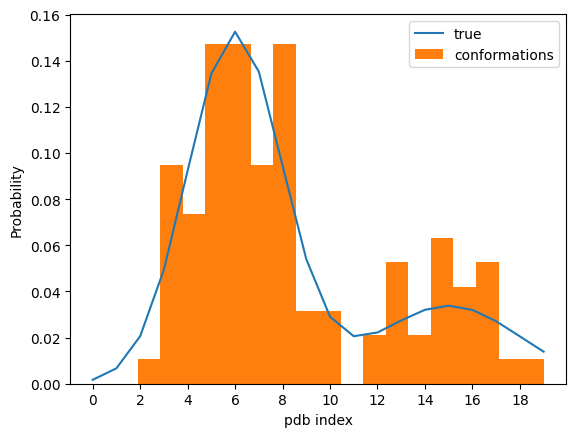

In [73]:
# this is reading out the true conformation index of each image
conformations = extra_info["conformation"]

# compute pdf output on a 1d grid
x = jnp.linspace(0, 19, 20)
dx = x[1] - x[0]
    
# normalize output to integrate to 1 on the grid 
weights = jnp.exp(mixture.log_prob(x))
weights /= weights.sum()
plt.plot(x, weights, label='true', color="C0")
plt.hist(conformations, bins=20, range=(0, 19), density=True, label='conformations', color="C1")
plt.xticks(jnp.arange(0, 20, 2))
plt.xlabel('pdb index')
plt.ylabel('Probability')  
plt.legend()
plt.show()


In [90]:
def _pointer_to_vmapped_parameters(imaging_pipeline):
    output = (
        imaging_pipeline.scattering_theory.transfer_theory.ctf.defocus_in_angstroms,
        imaging_pipeline.scattering_theory.transfer_theory.ctf.astigmatism_in_angstroms,
        imaging_pipeline.scattering_theory.transfer_theory.ctf.astigmatism_angle,
        imaging_pipeline.scattering_theory.transfer_theory.ctf.phase_shift,
        imaging_pipeline.scattering_theory.transfer_theory.envelope.b_factor,
        imaging_pipeline.scattering_theory.structural_ensemble.pose.offset_x_in_angstroms,
        imaging_pipeline.scattering_theory.structural_ensemble.pose.offset_y_in_angstroms,
        imaging_pipeline.scattering_theory.structural_ensemble.pose.view_phi,
        imaging_pipeline.scattering_theory.structural_ensemble.pose.view_theta,
        imaging_pipeline.scattering_theory.structural_ensemble.pose.view_psi,
        imaging_pipeline.scattering_theory.structural_ensemble.conformation
    )
    return output

def _get_imaging_pipeline_filter_spec(imaging_pipeline):
    return get_filter_spec(imaging_pipeline, _pointer_to_vmapped_parameters)


# Trying to compute likelihoods


In [ ]:
#@eqx.filter_jit
def compute_log_likelihood_single_conformation(
    potential, observed_images, observed_imaging_pipeline_vmap, observed_imaging_pipeline_novmap, config
):

    observed_imaging_pipeline = eqx.combine(observed_imaging_pipeline_vmap, observed_imaging_pipeline_novmap)

    structural_ensemble = cxs.SingleStructureEnsemble(
        potential, observed_imaging_pipeline.scattering_theory.structural_ensemble.pose
    )

    scattering_theory = cxs.WeakPhaseScatteringTheory(
        structural_ensemble=structural_ensemble,
        potential_integrator=cxs.FourierSliceExtraction(interpolation_order=1),
        #potential_integrator = cxs.GaussianMixtureProjection(),
        transfer_theory=observed_imaging_pipeline.scattering_theory.transfer_theory,
    )

    instrument_config = sim.instrument_config_from_params(config) 

    simulated_imaging_pipeline = cxs.ContrastImagingPipeline(
        instrument_config, scattering_theory
    )
    
    return compute_log_likelihood(observed_images, simulated_imaging_pipeline, variance=jnp.mean(noise_power_sq))

def compute_log_likelihood(observed_images, simulated_imaging_pipeline, variance):
    simulated = simulated_imaging_pipeline.render()
    print(simulated.shape)
    print(observed_images.shape)
    log_likelihood = -jnp.sum(((simulated - observed_images)**2/(2 * variance)))
    return log_likelihood 


#@eqx.filter_jit
@partial(eqx.filter_vmap, in_axes=(0, None, None, None), out_axes=0)
def compute_log_likelihood_all_images_single_conformation(atom_positions, images, pipeline_vmap, args):

    atom_identities, b_factors, parameter_table, instrument_config, pipeline_novmap = (
        args
    )

    atom_potential = cxs.PengAtomicPotential(
        atom_positions,
        atom_identities,
        b_factors,
        scattering_factor_parameter_table=parameter_table,
    )

    real_voxel_grid = atom_potential.as_real_voxel_grid(
        (instrument_config.shape[0],) * 3,
        instrument_config.pixel_size,
        batch_size_for_z_planes=10,
    )

    voxel_potential = cxs.FourierVoxelGridPotential.from_real_voxel_grid(
        real_voxel_grid,
        instrument_config.pixel_size
    )

    
    log_likelihoods = jax.lax.map(
        lambda x: compute_log_likelihood_single_conformation(
            potential=voxel_potential, observed_images=images, observed_imaging_pipeline_vmap=x, observed_imaging_pipeline_novmap=pipeline_novmap, config=config
        ),
        xs=pipeline_vmap,
        batch_size=10,
    )

    return log_likelihoods


In [95]:
pdb_fnames = config["models_fnames"]
path_to_models = config["path_to_models"]
filename = path_to_models + "/" + pdb_fnames[0]
_, atom_identities, b_factors = read_atoms_from_pdb(
    filename, get_b_factors=True)
parameter_table = get_tabulated_scattering_factor_parameters(atom_identities)

instrument_config = sim.instrument_config_from_params(config) 

args = (atom_identities, b_factors, parameter_table, instrument_config, observed_imaging_pipeline_novmap)

atom_positions_all = []
for i in range(len(pdb_fnames)):
    filename = path_to_models + "/" + pdb_fnames[i]
    atom_positions, atom_identities, b_factors = read_atoms_from_pdb(
    filename, get_b_factors=True
    )
    atom_positions_all.append(atom_positions)
atom_positions_all = jnp.stack(atom_positions_all)
print(atom_positions_all.shape)

(20, 9758, 3)


In [97]:
print(observed_imaging_pipeline_vmap)
likelihood = compute_log_likelihood_all_images_single_conformation(atom_positions_all, noised_images,observed_imaging_pipeline_vmap, args)



ContrastImagingPipeline(
  instrument_config=InstrumentConfig(
    shape=(None, None),
    pixel_size=None,
    voltage_in_kilovolts=None,
    electrons_per_angstrom_squared=None,
    padded_shape=(None, None),
    pad_mode=None
  ),
  scattering_theory=WeakPhaseScatteringTheory(
    structural_ensemble=DiscreteStructuralEnsemble(
      conformational_space=(
        PengAtomicPotential(
          atom_positions=None,
          scattering_factor_a=None,
          scattering_factor_b=None,
          b_factors=None
        ),
        PengAtomicPotential(
          atom_positions=None,
          scattering_factor_a=None,
          scattering_factor_b=None,
          b_factors=None
        ),
        PengAtomicPotential(
          atom_positions=None,
          scattering_factor_a=None,
          scattering_factor_b=None,
          b_factors=None
        ),
        PengAtomicPotential(
          atom_positions=None,
          scattering_factor_a=None,
          scattering_factor_b=None,
  

[ 0 19 19  0  1  0  0  2 19  0 13  9  0  0  5  2 19 19 18  2  9  0  0  0
 13 16  0  1  0  8 19  2  4  0 19 14  0 19  0  0  3  0 13  0 15  0  0 19
  0  0 19 19  0 13  0  0  4  0  1  0  0  0  0  0  5 19  0  0  0  0  0 10
 11  0  0  0  0 10 16 13  5  2 12  0 14  0  0  0  0  0 13  0  0  0 17  2
 19  0 19  0]
(20, 100)
[-8.54304669e+08 -1.10478715e+09 -9.13791369e+08 -9.29614371e+08
 -9.79611054e+08 -1.00155714e+09 -9.47645151e+08 -1.00251316e+09
 -1.00060391e+09 -1.07803648e+09]
[-8.65392122e+08 -1.13045470e+09 -8.94428976e+08 -9.52176360e+08
 -9.86153787e+08 -1.03115335e+09 -9.75305503e+08 -1.01824723e+09
 -9.71408958e+08 -1.13598891e+09]


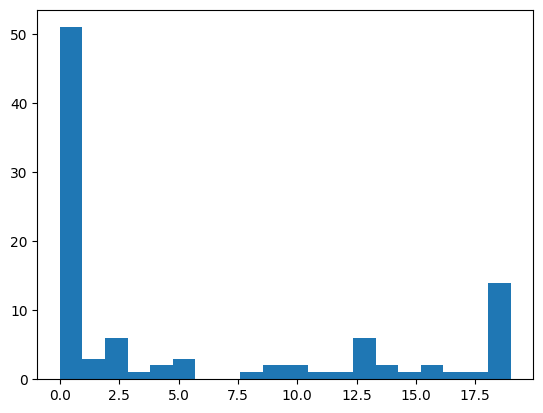

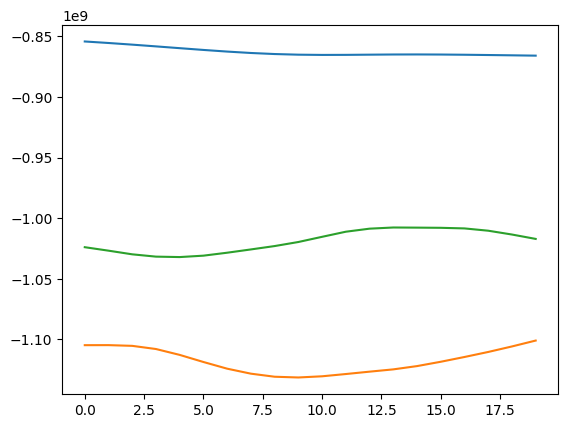

In [86]:
x = jnp.argmax(likelihood, axis = 0)
print(x)
print(likelihood.shape)
print(likelihood[0, 0:10])
print(likelihood[10, 0:10])

plt.hist(x, bins=20)

plt.figure()
plt.plot(likelihood[:, 0])
plt.plot(likelihood[:, 1])
plt.plot(likelihood[:, 10])


